# MNS - Biological Plausible Deep Learning

In [1]:
!pip install -r requirements.txt --quiet

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Import Packages
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

# Import tf for tensorboard monitoring of training
import tensorflow as tf

# Import Network Architectures
from DNN import DNN, eval_dnn
from CNN import CNN, eval_cnn

# Import log-helper/learning plot functions
from helpers import *
from plotting import *
from logger import get_latest_log_fname, process_logger

# Import Bayesian Optimization Module
from bayesian_opt import BO_NN

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print("Torch Device: {}".format(torch.cuda.get_device_name(0)))
else:
    print("Torch Device: Local CPU")
    
# Remove files in log dir
log_dir = os.getcwd() + "/logs"
if not os.path.exists(log_dir):
    os.makedirs(directory)
    print("Created New Log Directory")
else:
    filelist = [ f for f in os.listdir(log_dir) if f.endswith(".bak") ]
    for f in filelist:
        os.remove(os.path.join(mydir, f))
    print("Deleted Old Log Files in Existing Log Directory")

Torch Device: Local CPU
Deleted Old Log Files in Existing Log Directory


# Load dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data', 
                                             train=True, 
                                             transform=transforms.ToTensor(),  
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data', 
                                            train=False, 
                                            transform=transforms.ToTensor())

In [4]:
# MNIST dataset
X, y = get_data(num_samples=70000)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    random_state=0)

# Simple Feedforward Neural Net

In [6]:
# Define batchsize for data-loading/Epochs for training
batch_size = 100
num_epochs = 5
learning_rate = 0.001

# Instantiate the model with layersize and Logging directory
dnn_model = DNN(h_sizes=[784, 500], out_size=10)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=learning_rate)

In [7]:
model = train_model("dnn", dnn_model, num_epochs,
                    X, y, batch_size,
                    device, optimizer, criterion,
                    model_fname ="models/temp_model_dnn.ckpt",
                    verbose=True, logging=True)

# Get test error
score = get_test_error("dnn", device, model, X_test, y_test)
print("Test Accuracy: {}".format(score))

train | epoch  1 | acc: 0.9041 | loss: 0.3388 | time: 3.01
valid | epoch  1 | acc: 0.9537 | loss: 0.1591 | time: 0.22
--------------------------------------------------
train | epoch  2 | acc: 0.9623 | loss: 0.1278 | time: 3.68
valid | epoch  2 | acc: 0.9675 | loss: 0.1098 | time: 0.23
--------------------------------------------------
train | epoch  3 | acc: 0.9758 | loss: 0.0810 | time: 3.67
valid | epoch  3 | acc: 0.9722 | loss: 0.0930 | time: 0.23
--------------------------------------------------
train | epoch  4 | acc: 0.9835 | loss: 0.0562 | time: 3.67
valid | epoch  4 | acc: 0.9741 | loss: 0.0846 | time: 0.22
--------------------------------------------------
train | epoch  5 | acc: 0.9889 | loss: 0.0403 | time: 3.85
valid | epoch  5 | acc: 0.9762 | loss: 0.0786 | time: 0.24
--------------------------------------------------
Test Accuracy: 0.987314285714


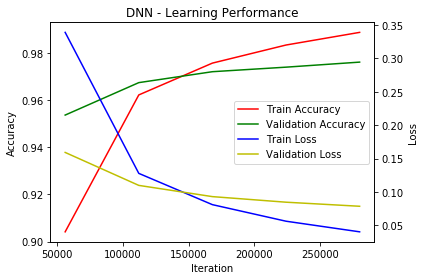

In [8]:
log_fname = get_latest_log_fname(log_dir)
its, train_loss, val_loss, train_acc, val_acc = process_logger(log_fname)
plot_learning(its, train_acc, val_acc, train_loss, val_loss, "DNN - Learning Performance")

In [9]:
# Run 3-fold cross-validation on specific architecture
eval_dnn(batch_size, learning_rate,
         num_layers=1, h_l_1=500,
         num_epochs=5, k_fold=3, verbose=True)

Batchsize: 100
Learning Rate: 0.001
Architecture of Cross-Validated Network:
	 Layer 0: 784 Units
	 Layer 1: 500 Units
Cross-Validation Score Fold 1: 0.968117929379
Cross-Validation Score Fold 2: 0.969356705096
Cross-Validation Score Fold 3: 0.969225493978


0.968900042817752

In [10]:
# Run Bayesian Optimization (UCB-Acquisition Fct) on DNN
hyper_space_dnn = {'batch_size': (10, 500),
                   'learning_rate': (0.0001, 0.05),
                   'num_layers': (1, 6),
                   'h_l_1': (30, 500),
                   'h_l_2': (30, 500),
                   'h_l_3': (30, 500),
                   'h_l_4': (30, 500),
                   'h_l_5': (30, 500),
                   'h_l_6': (30, 500)}

opt_log = BO_NN(3, eval_dnn, hyper_space_dnn, verbose=True)

BO iter  1 | cv-acc: 0.9515 | best-acc: 0.9515 | time: 34.08
BO iter  2 | cv-acc: 0.9592 | best-acc: 0.9592 | time: 36.59
BO iter  3 | cv-acc: 0.8799 | best-acc: 0.9592 | time: 35.48


# Simple Convolutional Neural Network

In [7]:
# --- Conflict defining network when DNN already ran
# ConvNet Parameters
batch_size = 100
ch_sizes = [1, 16, 32]
k_sizes = [5, 5]
stride = 1
padding = 2
out_size = 10
num_epochs = 2
learning_rate = 0.001

# Instantiate the model with layersizes, Loss fct, optimizer
cnn_model = CNN(ch_sizes, k_sizes,
                stride, padding, out_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [8]:
model = train_model("cnn", cnn_model, num_epochs,
                    X, y, batch_size,
                    device, optimizer, criterion,
                    model_fname ="models/temp_model_cnn.ckpt",
                    verbose=True, logging=True)

# Get test error
score = get_test_error("cnn", device, model, X_test, y_test)
print("Test Accuracy: {}".format(score))

train | epoch  1 | acc: 0.9431 | loss: 0.2182 | time: 61.04
valid | epoch  1 | acc: 0.9819 | loss: 0.0645 | time: 3.99
--------------------------------------------------
train | epoch  2 | acc: 0.9843 | loss: 0.0519 | time: 62.28
valid | epoch  2 | acc: 0.9856 | loss: 0.0495 | time: 3.78
--------------------------------------------------
Test Accuracy: 0.987485714286


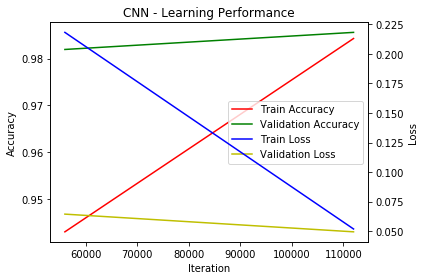

In [9]:
log_fname = get_latest_log_fname(log_dir)
its, train_loss, val_loss, train_acc, val_acc = process_logger(log_fname)
plot_learning(its, train_acc, val_acc, train_loss, val_loss, "CNN - Learning Performance")

In [15]:
# Run 3-fold cross-validation on specific architecture
eval_cnn(batch_size, learning_rate, num_layers=2,
         ch_1=16, ch_2=32, k_1=5, k_2=5,
         stride=1, padding=2,
         k_fold=2, verbose=True)

Batchsize: 100
Learning Rate: 0.001
Architecture of Cross-Validated Network:
	 Layer 1: 16 Channels, 5 Kernel Size
	 Layer 2: 32 Channels, 5 Kernel Size
Cross-Validation Score Fold 1: 0.974859297774
Cross-Validation Score Fold 2: 0.970426036517


0.972642667145946

In [20]:
# Run Bayesian Optimization (UCB-Acquisition Fct) on DNN
hyper_space_cnn = {'batch_size': (10, 500),
                   'learning_rate': (0.0001, 0.05),
                   'num_layers': (1, 5),
                   'ch_1': (3, 64),
                   'ch_2': (3, 64),
                   'ch_3': (3, 64),
                   'ch_4': (3, 64),
                   'ch_5': (3, 64),
                   'k_1': (2, 10),
                   'k_2': (2, 10),
                   'k_3': (2, 10),
                   'k_4': (2, 10),
                   'k_5': (2, 10),
                   'stride': (1, 3),
                   'padding': (1, 3)}

opt_log = BO_NN(3, eval_cnn, hyper_space_cnn, verbose=True)

{'ch_1': 369, 'ch_2': 30, 'ch_3': 172, 'ch_4': 99, 'ch_5': 73, 'k_1': 3, 'k_3': 5, 'k_2': 5, 'k_5': 5, 'k_4': 6, 'batch_size': 214, 'padding': 3, 'stride': 1, 'num_layers': 2, 'learning_rate': 0.0342924530697983}


KeyboardInterrupt: 

## Guergiev et al (2017)

In [ ]:
import comp_dl as dl

# silence 80% of feedback weights
dl.use_sparse_feedback = True

# set training parameters
f_etas = (0.21, 0.21)
b_etas = None
n_epochs = 10
n_training_examples = 60000

# create the network -- this will also load the MNIST dataset files
net = dl.Network(n=(500, 10))

# train the network
net.train(f_etas, b_etas, n_epochs,
          n_training_examples, save_simulation=True,
          simulations_folder="Simulations",
          folder_name="Example Simulation")

# re-load the saved simulation & network
net, f_etas, b_etas, n_training_examples = dl.load_simulation(latest_epoch=9, folder_name="Example Simulation", simulations_folder="Simulations")

# train the network for another 10 epochs
net.train(f_etas, b_etas, n_epochs, n_training_examples, save_simulation=True, simulations_folder="Simulations", folder_name="Example Simulation")

In [ ]:
nonspiking_mode         = True  # whether to run in non-spiking mode (real-valued outputs)
use_rand_phase_lengths  = True  # use random phase lengths (chosen from Wald distribution)
use_rand_plateau_times  = False # randomly sample the time of each neuron's apical plateau potential
use_conductances        = True  # use conductances between dendrites and soma
use_broadcast           = True  # use broadcast (ie. feedback to all layers comes from output layer)
use_spiking_feedback    = True  # use spiking feedback
use_spiking_feedforward = True  # use spiking feedforward input

use_symmetric_weights   = False # enforce symmetric weights
noisy_symmetric_weights = False # add noise to symmetric weights

use_sparse_feedback     = False # use sparse feedback weights
update_feedback_weights = False # update feedback weights
use_backprop            = False # use error backpropagation
use_apical_conductance  = False # use attenuated conductance from apical dendrite to soma
use_weight_optimization = True  # attempt to optimize initial weights
use_feedback_bias       = False # use biases in feedback paths
initial_test            = False # whether to do an initial test on the test set prior to training

record_backprop_angle   = False # record angle b/w hidden layer error signals and backprop-generated error signals
record_loss             = True  # record final layer loss during training
record_training_error   = True  # record training error during training
record_training_labels  = True  # record labels of images that were shown during training
record_phase_times      = False # record phase transition times across training
record_plateau_times    = False # record plateau potential times for each neuron across training
record_voltages         = False # record voltages of neurons during training (huge arrays for long simulations!)

# --- Jacobian testing --- #
record_eigvals          = False # record maximum eigenvalues for Jacobians
record_matrices         = False # record Jacobian product & weight product matrices (huge arrays for long simulations!)
plot_eigvals            = False # dynamically plot maximum eigenvalues for Jacobians

default_simulations_folder = 'Simulations/' # folder in which to save simulations (edit accordingly)
weight_cmap                = 'bone'         # color map to use for weight plotting

dt  = 1.0        # time step (ms)
mem = int(10/dt) # spike memory (time steps) - used to limit PSP integration of past spikes (for performance)

l_f_phase      = int(50/dt)  # length of forward phase (time steps)
l_t_phase      = int(50/dt)  # length of target phase (time steps)
l_f_phase_test = int(250/dt) # length of forward phase for tests (time steps)

integration_time      = l_f_phase - int(30/dt)      # time steps of integration of neuronal variables used for plasticity
integration_time_test = l_f_phase_test - int(30/dt) # time steps of integration of neuronal variables during testing

# 2nd set of hyperparameters
lambda_max = 0.2*dt # maximum spike rate (spikes per time step)

# kernel parameters
tau_s = 3.0  # synaptic time constant
tau_L = 10.0 # leak time constant

# conductance parameters
g_B = 0.6                                   # basal conductance
g_A = 0.05 if use_apical_conductance else 0 # apical conductance
g_L = 1.0/tau_L                             # leak conductance
g_D = g_B                                   # dendritic conductance in output layer

E_E = 8  # excitation reversal potential
E_I = -8 # inhibition reversal potential

# steady state constants
k_B = g_B/(g_L + g_B + g_A)
k_D = g_D/(g_L + g_D)
k_I = 1.0/(g_L + g_D)

# weight update constants
P_hidden = 20.0/lambda_max      # hidden layer error signal scaling factor
P_final  = 20.0/(lambda_max**2) # final layer error signal scaling factor

In [ ]:
if nonspiking_mode:
    # set parameters for non-spiking mode
    use_rand_phase_lengths  = False
    use_rand_plateau_times  = False
    use_conductances        = False
    use_spiking_feedforward = False
    use_spiking_feedback    = False
    record_phase_times      = False
    record_plateau_times    = False
    record_voltages         = False

    l_f_phase             = 2
    l_t_phase             = 2
    l_f_phase_test        = 2
    integration_time      = 1
    integration_time_test = 1
    mem                   = 1

In [ ]:
if use_rand_phase_lengths:
    # set minimum phase lengths
    min_l_f_phase = l_f_phase
    min_l_t_phase = l_t_phase